In [1]:
import pickle
import warnings
from math import sqrt
import shap
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import wbgapi as wb
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.9.1


In [93]:
data = wb.data.DataFrame('SP.DYN.LE00.IN', 'KOR', time= range(1980,2021), numericTimeKeys=True)
data =data.transpose()
data['EV_Total']=data['KOR']
data.drop(['KOR'], axis = 1,inplace=True)
data['date']=data.index
data['date'] = pd.to_datetime(data['date'],format='%Y')
data=data.set_index('date')

In [22]:

split_date = '2009'
df_training = data.loc[data.index <= split_date]
df_test = data.loc[data.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

30 days of training data 
 11 days of testing data 


In [23]:
autoModel = pm.auto_arima(data, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(data)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-23.882, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-51.684, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-25.802, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-52.379, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-50.533, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-54.045, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-53.547, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-52.122, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-53.676, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-54.935, Time=0.04 sec
 A

ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
order = autoModel.order

model = ARIMA(data, order=order,
                    enforce_stationarity=False,enforce_invertibility=False)
model_fit_arima=model.fit()   

In [25]:
X_train_pred = model_fit_arima.predict(start=30, end=40, dynamic=False)

<AxesSubplot:xlabel='date'>

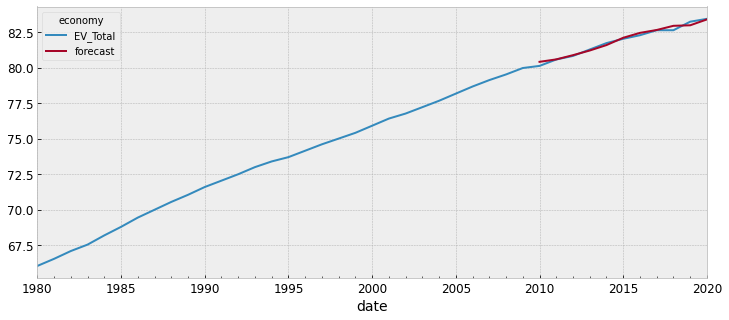

In [26]:
data2=data.copy()
data2["forecast"] = model_fit_arima.predict(start=30, end=41, dynamic=False)
data2[['EV_Total', "forecast"]].plot(figsize=(12,5))

In [27]:
print(r2_score(df_test, X_train_pred))

0.9742994974142148


In [41]:
autoModel2 = pm.auto_arima(data, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=1, stepwise=True)
autoModel2.fit(data)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-51.715, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-25.802, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-53.547, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-51.143, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-54.045, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-52.122, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-53.676, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-54.935, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-53.290, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-52.967, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.850 seconds


ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [37]:
order = autoModel2.order
seasonalOrder = autoModel2.seasonal_order

model = SARIMAX(data, order=order,
                    seasonal_order=seasonalOrder,enforce_stationarity=False,enforce_invertibility=False)
model_fit_sarimax=model.fit()   

In [38]:
X_train_pred2 = model_fit_sarimax.predict(start=30, end=40, dynamic=False)

<AxesSubplot:xlabel='date'>

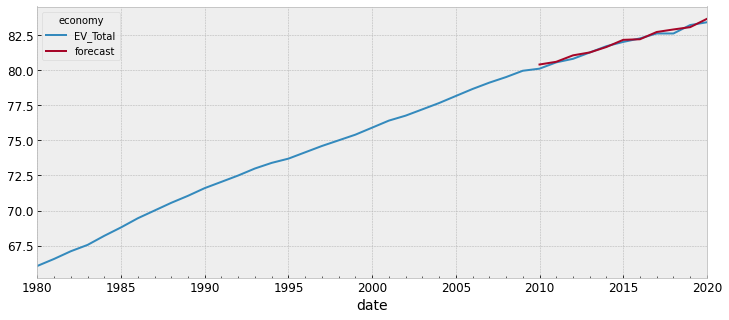

In [39]:
data3=data.copy()
data3["forecast"] = model_fit_sarimax.predict(start=30, end=41, dynamic=False)
data3[["EV_Total", "forecast"]].plot(figsize=(12,5))

In [40]:
print(r2_score(df_test, X_train_pred2))

0.9701137798874653


In [96]:
df = data[['EV_Total']]
df.columns = ['y']
df['ds']=data.index

In [97]:
df.head()

,y,ds
date,,
1980-01-01,66.046341,1980-01-01
1981-01-01,66.546341,1981-01-01
1982-01-01,67.095122,1982-01-01
1983-01-01,67.546341,1983-01-01
1984-01-01,68.195122,1984-01-01


In [99]:
m = Prophet()
m.fit(df)

# create forecast
future = m.make_future_dataframe(freq='Y',periods=10)
forecast = m.predict(future)

    # create plots
pred_plot = plot_plotly(m, forecast)
pred_plot

18:28:23 - cmdstanpy - INFO - Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing
